In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    #toxic_data['exc_count'] = toxic_data['comment_text'].str.count("\!")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

### Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./toxiccomments_train.csv', my_random_seed=125)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

### Model

In [5]:
from sklearn import linear_model

# alphas = [0, 0.5, 0.7, 5, 10, 50, 5000]

# for alpha in alphas:
rdg = linear_model.RidgeClassifier(alpha=20, fit_intercept=True, normalize=True, copy_X=True, max_iter=None, tol=0.001, class_weight='balanced', solver='sag', random_state=None)
rdg.fit(X_train, y_train)
rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 12619, 'TN': 104948, 'FP': 9731, 'FN': 358, 'Accuracy': 0.9209672870840383, 'Precision': 0.5646085011185682, 'Recall': 0.9724127302149957, 'desc': 'rdg_train'}


### ROC plot to compare performance of various models and fits

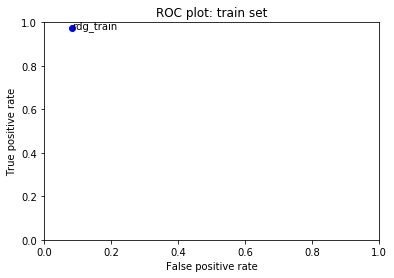

In [6]:
fits = [rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [7]:
rdg_predictions = rdg.predict(X_train)

In [8]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
144
Gamergate, why? 

Why go to all this effort when your edits will certainly be undone once you're topic banned?
* * * * * * * * * 
1339
Pooooooooooooooooooooooooove 

Hi M8
* * * * * * * * * 
1406
Ok, you've been reported because I clearly explained about IPs that I wasnt doing anything and u keep sendimg me messages and haven't done anything to fix the situation.
If you bothered to learn about how the internet worked you'd understand that there are a very limited amount of ip4 addresses and with IPV6 there are LOADS more. So clearly somebody ELSE was using MY ip to edit goodfellas then turned off their computer and when i turned mine on i got THEIR ip. So get a life n00b and learn how to use a computer before you go putting people in their places. Your probably a WASP aswell. Just the type.
* * * * * * * * * 
2005
Of course the Golden Rule is a prerequisite for a peaceful religion, how on earth can you not expect it to be? Muslims are allowed in the Qur

17856
Wait a minute biggie wasn't 8 feet 8 inches tall
* * * * * * * * * 
17915
Quit stalking me! 

There are more important things to do in life. Thanks in advance. 2001:558:6026:97:44AF:E2BF:9B1E:3DD9
* * * * * * * * * 
18063
If I stop I will not be blocked? Do you mean that - will you give me your word? 169.57.0.200
* * * * * * * * * 
18509
vandal, very good, i'm surprised the 14 yr old can even spell
* * * * * * * * * 
18831
"
I like messing around with your talk page. Can I do it every day? — Nearly Headless Nick  {C} {L} "
* * * * * * * * * 
19001
If you don't care then why the heck did you even start this discussion? Your arguments are still invalid I'm afraid. The problem is you actually checkmated yourself by quoting the source rofl.
* * * * * * * * * 
19316
"
Uh, how are you not attacking me and not addressing my argument when you bring up ""AOLisms""? I don't believe my arguments boil down to these. Ironically, your previous comment is an ad hominem attack.  -  "
* * * * * *

31800
"

I am extending to you an official apology for your perceptions of incivility on my part. I expect an apology from you for your ""Shut up"" quip. "
* * * * * * * * * 
32019
When I added it they reverted my edition. Not they added it and they didn't. Wtf?
* * * * * * * * * 
32049
You know what he'll say. NOW this discussion is over. HA!
* * * * * * * * * 
32290
REDIRECT Talk:Allianz EurOpen Strasbourg
* * * * * * * * * 
32345
until an admin tells us what he/she thinks
* * * * * * * * * 
32362
Make up and spandex are
* * * * * * * * * 
32480
Shadow Hog, now you are just being a fool, you have no evidence to stand up for what you are saying, while theres a huge list of evidence, heck MegamanZero even has proof from a Capcom member! -Zeldarulah
* * * * * * * * * 
32528
"

Chillum. In a fair project, what you said would be completely true.  But, the project stinks of Bishonen's rancid smell. As I said in my valid and now removed comment, Bishonen's few asses always rush to cover up 

48379
But these are the facts and the whole world knows it. Just because you are Sunni doesn't mean you should try to suppress factual comments about your extremist religion. What do you think this war on terror is all about? Who do you think bombed WTC? Who bombed London on 7/7? All Sunnis. Who carried out all those bombing campaign in Bangladesh killing lots of innocent people? All Sunnis. Who is doing all those suicide bombings in Pakistan? All Sunnis. So what is your problem? Why are you so subversive to facts? I thought wiki was all about facts and not POV. May be you should try to do something to fix your religion rather than trying to suppress facts. The facts that everyone knows anyway and your effort is futile. Come out of this Ostrich mentality. You are not fooling anyone.
* * * * * * * * * 
48426
and silence me from criticising the poor miscarriage of justice over this
* * * * * * * * * 
48531
[User:Alderbourne|alderbourne]]  
Wow, again I gotta say, what a disgusting commen

61692
This is the worst article on Wikipedia. 

The fact that Wikipedia cites leftist cranks who believe that hatred of a religion is somehow racism is just ridiculous.
* * * * * * * * * 
61946
i dont even know what to do on this site.
* * * * * * * * * 
62287
IPs change. 190.46.98.195
* * * * * * * * * 
62601
Oppose Subject alone is noteworthy. 72.45.254.78
* * * * * * * * * 
62884
Wanna have some fun? TTLY!!!!!! I KNOW LIKE YEAH OHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
* * * * * * * * * 
63052
Attack?
I don't think this was an attack. You're wrong dude
* * * * * * * * * 
63114
"

 and Then i was Walking down the street in India and It Was Gandhi 

and He Was All 'i don't eat the Smoked Meats but Toddt he's So Gay"""
* * * * * * * * * 
63150
Iamnotsteve here, just a little PO'ed that I got blocked AGAIN for another user. BTW, android, that was insulting. Anywho, I THINK a buddy and I figured out who steve is. Great policy folks, btw. Nothing like blocking a multiuser IP for a 

72864
Tell someone 

Its a fact.i in 3 children would have experianced cyber bullying by the time they are 15 years old. This is caused to them not telling an family member or an adult. So if you are someone who is experiancing cyber bullying, i am warning you, tell someone you trust
Cyber bullying can lead to suicide. It can get very serious if you deal it the wrong way.

Liz
* * * * * * * * * 
73711
How is it point of view? its a fact! Rhino did beat up Daniels with a chair, did you not see the match Jay316
* * * * * * * * * 
73920
Ok! gonna get on it as soon as possible.
* * * * * * * * * 
74137
: you do know that you are a dupe, right?  just sayin.
* * * * * * * * * 
74148
Ps Paul Klenk is right. You will not find a fairer, more even handed editor here. He cares passionately about his excellent work at Wikipedia. I observed with my very own eyes how, though he literally bent over backwards for these people, they just spit on him like he was refuse. Something's got to be done about 

87663
Flogging a dead horse
* * * * * * * * * 
88235
Toy soldiers? That made NO sense but okay buddy....lol 24.153.216.129
* * * * * * * * * 
88400
"

BEN'S new sockpuppet 
HELLO BEN BURCH see User:BenBurch, I see you got your self a sockpuppet, I have a few my self...

Any rate, your editing on Peter Roskam Bio  article is going to get contentious again
due to your tenuous editing..  see example is this what you want...??? Why can't you be content with NPOV rather
then pushing your political agenda??? Is you hated for Republicans and Pete that great that you compromise principles of fair play, free speech, NPOV??? Is ""ends justified the means"" is the only principle you believe? Is this so important to you that you have to resort to Chicago street thug tactics, because  you your arguments stand on merit alone??? Why do you, and your Democratic friends have to resort this?  If you have issues with the Republicans and Pete, Then get involved with you local Democratic organization, rath

95515
Hi.  I don't know who Col. Hauler is, but its not me.  Boy you guys clutch at straws with your sock puppet allegations, don't you?  I just saw a situation where his comments were being censored, that's all.  Does it make me a sock puppet because I did this?  Its a stretch, for sure.

So does this mean that you think that
* * * * * * * * * 
95693
Listen to them... 

...children of the night. What music they make. 62.216.118.84
* * * * * * * * * 
96163
UtherSRG, the more you talk the more you highlight your inferiority.  Consensus means nothing.  Go ahead and block me, it won't matter.  You are wrong.  You know it, and I know it.  All those other people who agree with you a wrong too, and they know it.
* * * * * * * * * 
96288
"

Reaper Eternal thanks for removing the web host block but what about the personal attacks of the editor I was responding to, calling another editors good faith edits ""trash"" several times, and no call to remove that, is that kind of editing ok with you?2

110050
Per the proposed guideline at WP:NART.
* * * * * * * * * 
110163
Wow! I shall walk a little taller for that!
* * * * * * * * * 
110439
Sorry I didnt Know im just new i better read the rules properly
* * * * * * * * * 
110448
Sora, Geno, WW Link, and Ganondorf confirmed 

A RELIABLE LEAKER (they do exist, live with it), revealed that WW Link and Ganondorf are in, and Sora and Geno are in as well.He said many things, like a Twilight Town Stage, and Dark Riku as a boss in the SSE (Apparently Link and PT fight him). The leaker's father was apparently friends with a ex-navy Nintendo employee. Reliable Source? I'd say yes. -
* * * * * * * * * 
110452
you're a complete tool=

look at your talk page, its just pages and pages of people asking why you intefered with their shit without being asked.
first u come into a private converstaion between me and andother wikipedia retard and threaten to block me and revert my contributions
next u threaten to block me because i had the audacity to w

124989
click me and keep off my page, powertripper.
* * * * * * * * * 
125022
" 

 Well, so am I! - don't worry about it. It's just a spam site which is sucking up wikipedia content, userpages included -  ☺ "
* * * * * * * * * 
125252
Hey fluffy, your pretty fluffy
* * * * * * * * * 
125541
Miranda Is A very Brutal Boss. She Makes Life Hell for Assistant Andy while she does everything she can for Miranda
* * * * * * * * * 
125544
Constantine got dumped by Molly, but no one knows why.  Molly dumped him because she thought that Constantine thinks of himself as a sexy beast.  He actually looks like a something Winnie the Pooh would find in the bathroom.  Constantine still thinks that Molly likes him, but she actually wants to kill Constantine for being so ugly.  

                                     Mike Polito
* * * * * * * * * 
125578
Man... what's your source?
* * * * * * * * * 
126388
discussion on this subject]] and explain yourself. But whatever you do, do not write anything with a

### Test

In [9]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 2856, 'TN': 25732, 'FP': 2935, 'FN': 392, 'Accuracy': 0.8957543474855084, 'Precision': 0.49317907097219826, 'Recall': 0.8793103448275862, 'desc': 'rdg_test'}


### ROC plot to compare performance of various models and fits

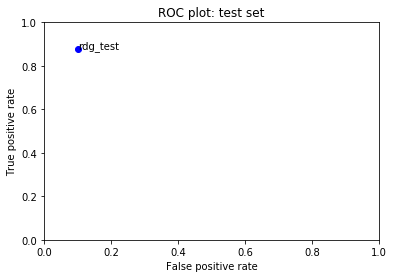

In [10]:
fits = [rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### SUBMISSION

In [11]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='./toxiccomments_test.csv', my_random_seed=125, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

In [12]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.29905852550207623


In [13]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [14]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [15]:
my_submission.shape

(153164, 2)

In [16]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)